# Muscle artefacts removal (component decomposition)

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.interpolate as spi
from scipy import signal
from sklearn.decomposition import PCA,FastICA


# ! pip install pyts
from pyts.decomposition import SingularSpectrumAnalysis

# !pip install EMD-signal
from PyEMD import EEMD
# from pyhht.emd import EMD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Import Dataset

In [4]:
data = pd.read_excel('datasets/dataset.xlsx')
data

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3
...,...,...,...,...,...,...,...,...
7115,23896.6,3893.1,37567.5,38276.6,11183.1,4515.5,31611.9,48532.8
7116,23850.2,3780.5,37514.3,38075.4,11119.7,4572.2,31551.9,48566.2
7117,23766.2,3644.2,37432.3,37477.1,11029.8,4755.0,31464.2,47165.5
7118,23768.4,3709.8,37443.6,37362.9,11048.4,4738.0,31481.5,46410.0


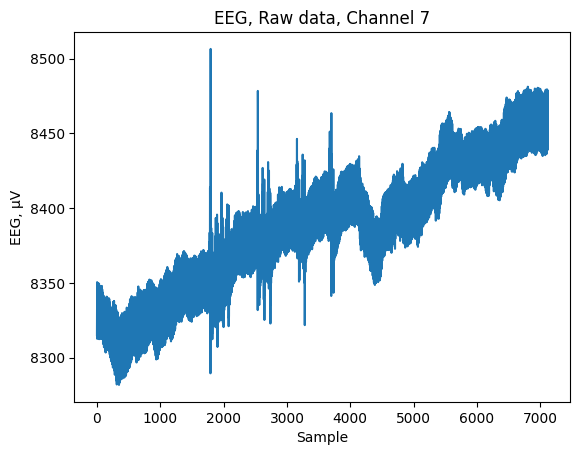

In [5]:
# select the data from the seventh channel
channel = 6
channel_data = data.iloc[:, channel]
# convert from Digital Value of Analog Digital converter (ADC) ADS1299 to microvolts
channel_data = round(1000000*4.5*(channel_data/16777215),2)
# plot the EEG data
plt.plot(channel_data)
plt.title(f"EEG, Raw data, Channel {channel+1}")
plt.ylabel('EEG, µV')  # Data from ADS1299
plt.xlabel('Sample')
plt.show()

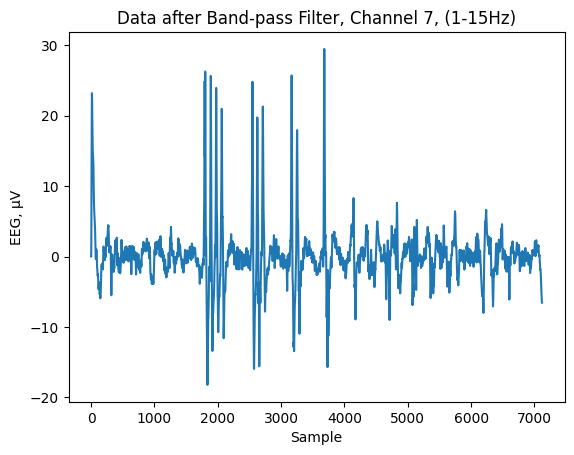

In [6]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 15  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Data after Band-pass Filter, Channel " +  str(channel+1) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

In [10]:
# apply the band-pass filter for the whole dataset
data_bp_filtered = data.copy()  # copy the data

for ch in range(data_bp_filtered.shape[1]):
    data_bp_filtered.iloc[:, ch] = butter_highpass_filter(
        data=data_bp_filtered.iloc[:, ch],
        cutoff=cutoff_high,
        nyq=nyq,
        order=5)
    data_bp_filtered.iloc[:, ch] = butter_lowpass_filter(
        data=data_bp_filtered.iloc[:, ch],
        cutoff=cutoff_low,
        nyq=nyq,
        order=4)